In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import xarray

import abtem
import ase
import pickle
import os
from tempfile import TemporaryFile
from tqdm.auto import tqdm
# from tqdm.auto import tqdm  # notebook compatible
import time

# from ase.lattice.spacegroup import crystal
from ase.spacegroup import crystal
from abtem.visualize import show_atoms
from ase.io import read
from ase.visualize import view
from ase import Atoms
from abtem.parametrizations import LobatoParametrization

from mp_api.client import MPRester

## functions 

In [2]:
def structure_from_MP(material_id , API_key = "cxnJrpd5pqO3S94GGmwCc3mlqtwYG9Yo", only_ase_Structure = True, conventional_unit_cell = False):
    #connecting to MP database with API key
    mpr = MPRester(API_key)
    
    # Fetch the structure for the material
    structure = mpr.get_structure_by_material_id(material_id, conventional_unit_cell = conventional_unit_cell)
    
    #retriveing the coorniates and species of atoms
    coordinates = []
    coordinates_frac = []
    species = []
    species_name = []
    structure_abc = np.array(structure.lattice.abc)
    structure_angles = np.array(structure.lattice.angles)
    alpha, beta, gamma = np.deg2rad(structure_angles[0]), np.deg2rad(structure_angles[1]), np.deg2rad(structure_angles[2])
    #calculating the volume:
    V = structure_abc[0]*structure_abc[1]*structure_abc[2]*np.sqrt(1-np.cos(alpha)**2-np.cos(beta)**2
        -np.cos(gamma)**2+2*np.cos(alpha)*np.cos(beta)*np.cos(gamma))
    
    #making the matrix to convert vectors from fractional coordinates to cartesian coordinates:
    A = np.transpose([[structure_abc[0],
          0,
          0],
           [structure_abc[1]*np.cos(gamma),
            structure_abc[1]*np.sin(gamma),
            0],
           [structure_abc[2]*np.cos(beta),
             structure_abc[2]*(np.cos(alpha)-np.cos(beta)*np.cos(gamma))/np.sin(gamma), 
            V/(structure_abc[0]*structure_abc[1]*np.sin(gamma)) ]
         ])
    
    for s in structure:
            coordinates_frac.append(s.frac_coords) #would give fractional coordinates instead
            coordinates.append(np.dot(A,np.transpose(s.frac_coords))) #cartesian coordinates calculated from fractional coordinates
            species.append(s.specie.Z) #atomic number
            species_name.append(s.specie) #would give strings (e.g. "Fe") instead of atomic number
    
    #saving data as dictionary
    lattice = {'structure':{'Name' : species_name, 'Atmoic Number' : species , 'Coordniates' : coordinates ,
              'Fractional coordinates' : coordinates_frac}, 'vector' : {'distance' : structure_abc, 'angles': structure_angles }}
    
    #making the unit cell compact form for ase (a,b,c,alpha,beta,gamma)
    cell = np.copy(np.append(lattice['vector']['distance'],lattice['vector']['angles']))
    ase_structure = Atoms(species, coordinates, cell = cell) #creating the strucutre in ase
    if only_ase_Structure:
        return ase_structure #returning only ase structure object
    else:
        return ase_structure, cell #returning ase structure object as well as cell dictionary


In [3]:
def rot_ase_layer(atoms, theta):
    rot_center = [atoms.cell[0][0]*0.5, atoms.cell[1][1]*0.5, atoms.cell[2][2]*0.5]#defining center of rotation of structure
    atoms.rotate(theta, 'z', center = rot_center) #rotation of second layer

In [4]:
def sampling_parameters(ase_structure, energy, resolution = 1):
    """making a dict with sampling paramateres. Units are in Å/Å^-1 and mrad"""
    
    f_nyquist = 0.5 # approximately double sampling rate of finest features of experiment
    Picture_size = np.max(ase_structure.cell[0:2])  #Å - taking the largest of coordinate in of the cell in the x-y plane
    delta_x = f_nyquist * resolution #pixel size length in Å
    N = Picture_size/delta_x  # number of pixels
    N = 2**math.ceil(math.log2(N)) #rounding up to nearest higher pixel count for FFT (as a factor of 2)
    delta_x = Picture_size/N # recalculating pixel size with respect to new gpts


    plane_wave = abtem.PlaneWave(gpts = N, extent=Picture_size,energy=energy)
    wavelength = plane_wave.wavelength #defining the wavelength of the source electrons given in Å

    reciprocal_P = round(1/(N*delta_x),6)
    k_max = round(f_nyquist/delta_x,6) #å^-1
    k_max_antialiasing = round(2/3 * k_max,6) 
    alpha = k_max_antialiasing * wavelength *10**3


    return {"energy":energy, "resolution":resolution, "Picture size":Picture_size,
            "Pixel size": delta_x, "gpts": N, "Wavelength" : wavelength,
            "Reciprocal pixel size": reciprocal_P, "k_max nyquist": k_max,
          "k_max antialiasing": k_max_antialiasing, "Angular limitied resolution": alpha}


In [5]:
def potential_build(ase_structure, energy, 
                    slice_thickness = 1, parametrization="lobato", 
                    projection="finite", resolution=1):
    """Builds structure potential of either Atoms or Frozen Phonons obeject. Units given in Å and eV"""

    #retrives sampling parameters
    Param = sampling_parameters(ase_structure, energy, resolution)
    
    return abtem.Potential(ase_structure, gpts=Param['gpts'], parametrization=parametrization, 
                           slice_thickness=slice_thickness, projection=projection)

In [6]:
def TEM_exit_wave(potential, input_wave, compute = True):
    exit_wave = input_wave.multislice(potential)
    if compute:
        exit_wave.compute()
    return exit_wave
    

In [7]:
def combine_layers(layer_1, layer_2, z_height):
    combined_layer  = layer_1 + layer_2
    combined_layer.cell[2][2] = z_height
    return combined_layer

In [8]:
def abtem_dict(ase_cell, theta, repetitions, interlayer_dist = 3, sliceThickness = 0.5):

    #create layer 1 from repetitions and 
    layer_1 =  ase_cell * repetitions 

    #Define padding and distance between layers
    xy_padding = layer_1.cell[0:2].max() *0.5 #xy vacuum 50% of layer size to avoid fringing
    z_height = 2*interlayer_dist+ase_cell.cell[2][2]
    z_padding = interlayer_dist/2 

    #applying vacuum
    layer_1.center(vacuum = xy_padding, axis=(0,1))
    layer_1.center(vacuum = z_padding, axis=2)

    #creating layer 2
    layer_2 = layer_1.copy()
    z_translation = [0,0,layer_1.cell[2][2]] #translation of layer2
    layer_2.translate(z_translation)


    #defining the sampling parameters:
    sampling_pam = sampling_parameters(layer_1, energy = 300e3, resolution = 0.2)
    #Make the ingoing plane wave:
    plane_wave = abtem.PlaneWave(energy =sampling_pam['energy'],
                                gpts = sampling_pam['gpts'],
                                extent = sampling_pam['Picture size'])
    ase_structures = []
    potentials = []
    exit_waves = []
    counter = 1
    total  = len(theta)
    for phi in theta:
        print('\nAngle number: {0}/{1}'.format(counter,total))    
        layer_3 = layer_2.copy() #make new instance of layer 2
        rot_ase_layer(layer_3,phi) #rotate new instance
        combined_layers = combine_layers(layer_1,layer_3, z_height)#combine new instance with fixed layer
        ase_structures.append(combined_layers)
        #build potential of new instance and add to list
        potential = potential_build(combined_layers, energy=sampling_pam['energy'], 
                    slice_thickness = sliceThickness,
                    projection="finite", resolution=sampling_pam['resolution'])
        print('\nPotential: {0}/{1} calculated'.format(counter,total))  
        potentials.append(potential)
        #build exit wave and add to list
        exit_wave = TEM_exit_wave(potential, plane_wave)
        exit_waves.append(exit_wave)
        print('\nExit wave: {0}/{1} calculated'.format(counter,total)) 
        counter +=1 

    return {'Rotation': theta, 'ASE structure':ase_structures,
                'Potential': potentials, 'Exit waves': exit_waves }

In [9]:
def reptitions_from_min_rep(ase_cell, repetitions):

    #get the cell vectors in the XY plane
    X = ase_cell.cell[0][0:2]
    Y = ase_cell.cell[1][0:2]


    #Calculate the fraction of the square section of the cell represented in the unit cell vectors 
    if Y[0]>=0:
        X_extent = 1-Y[0]/X[0] 
    else:
        X_extent = -Y[0]/X[0]
    
    Y_extent = 1-X[1]/Y[1]

    #calculate the minimum repetitions needed for full coverage
    X_rep = int(math.ceil(repetitions/X_extent))
    Y_rep = int(math.ceil(repetitions/Y_extent))

    return (X_rep,Y_rep,1)



In [10]:
def repetitinos_from_min_extent(ase_cell, extent):

    #get the cell vectors in the XY plane
    X = ase_cell.cell[0][0:2]
    Y = ase_cell.cell[1][0:2]

    
    #Calculate the fraction of the square section of the cell represented in the unit cell vectors 
    X_extent = abs(Y[0])/X[0]

    

    #calculate the minimum repetitions needed for full coverage
    X_rep = int( math.ceil( extent* (1/X[0]) * (1+X_extent) ) )
    Y_rep = int( math.ceil( extent / Y[1] ) ) 

    return (X_rep,Y_rep,1)


In [11]:
def make_cell_cubic(ase_cell, extent, rounding_error_limit = 0.0001):

    #get extent for making supercell a bit larger - gets cut down afterwards
    extents = repetitinos_from_min_extent(ase_cell, extent*1.2)
    supercell  = ase_cell * extents
    if supercell.cell[1][0]>0:
        supercell.translate([-supercell.cell[1][0],0,0])
    view(supercell)
    #redraw the supercell matrix as square in XY
    supercell.cell[0] = [extent,0,0]
    supercell.cell[1] = [0,extent,0]
    view(supercell)

    #remove all points that fall outside the supercell
    index = 0
    while index < len(supercell.positions):
        if (min(supercell.positions[index][0:2])<= - rounding_error_limit
        or max(supercell.positions[index][0:2])> extent+rounding_error_limit):
            supercell.pop(index)
        else:
            index+=1
    return supercell



In [165]:
def generate_ctf(Cs = -20e-6*1e10, energy=300e3, defocus ="scherzer" ):
   """generate Contrast Transfer function to be applied on exit wave
   
   Parameters
   ----------
   Cs : float
      the sperical abberation given in Å
   energy: float
      energy of the electron wave in eV
   defocus: str or float
      The defocus setting - either automatic as set to "scherzer" or a value in Å

   Returns
   -------
   ctf : abtem.CTF
      contrast transfer function object for the given parameters 
   """
   
   
   ctf = abtem.CTF(Cs=Cs, energy=energy, defocus=defocus)

   print(f"defocus = {ctf.defocus:.2f} Å")
   aberration_coefficients = {"C10": -ctf.defocus, "C30": Cs}

   return abtem.CTF(aberration_coefficients=aberration_coefficients, energy=ctf.energy) 
   

In [12]:
def gen_rotstack(ase_cell, Theta, repetitions, interlayer_dist=3, X=[0], Y=[0], sliceThickness = 0.5,
                  xy_padding  = 3, extent_as_unitcell = False,
                  save_exitwave = False, save_potentials = False, save_structures = False):
    """Function for getting data from many layers"""


    #create layer 1 from repetitions and 
    layer_1 =  ase_cell * repetitions 

    #Define padding and distance between layers
    #xy_padding = layer_1.cell[0:2].max() *0.5 #xy vacuum 50% of layer size to avoid fringing
    z_height = 2*interlayer_dist+ase_cell.cell[2][2]
    z_padding = interlayer_dist/2 

    #applying vacuum
    layer_1.center(vacuum = xy_padding, axis=(0,1))
    layer_1.center(vacuum = z_padding, axis=2)

    #creating layer 2
    layer_2 = layer_1.copy()
    z_translation = [0,0,layer_1.cell[2][2]] #translation of layer2
    layer_2.translate(z_translation)


    #defining the sampling parameters:
    sampling_pam = sampling_parameters(layer_1, energy = 300e3, resolution = 0.2)
    #Make the ingoing plane wave:
    plane_wave = abtem.PlaneWave(energy =sampling_pam['energy'],
                                gpts = sampling_pam['gpts'],
                                extent = sampling_pam['Picture size'])

    ase_structures = []
    potentials = []
    exit_waves = []


    A  = len(Theta)
    B = len(X)
    C = len(Y)
    D = int(sampling_pam['gpts'])

    data_save = np.zeros((A,B,C,D,D))    
    

    for k, phi in enumerate(tqdm(Theta, desc ='Angle number:', leave=False) ): 
        for j, x in enumerate(tqdm(X, desc ='X translation:', leave=False)):
            for l, y in enumerate(tqdm(Y, desc ='Y translation:', leave=False)):
                layer_3 = layer_2.copy() #make new instance of layer 2
                rot_ase_layer(layer_3,phi) #rotate new instance
                layer_3.translate([x,y,0]) #translate structure


                combined_layers = combine_layers(layer_1,layer_3, z_height)#combine new instance with fixed layer
                if save_structures:
                    ase_structures.append(combined_layers)

                #build potential of new instance and add to list
                potential = potential_build(combined_layers, 
                                            energy=sampling_pam['energy'], 
                                            slice_thickness = sliceThickness,
                                            projection="finite", 
                                            resolution=sampling_pam['resolution'],
                                            )
                if save_potentials:
                    potentials.append(potential)

                #build exit wave and add to list
                exit_wave = TEM_exit_wave(potential, plane_wave)
                if save_exitwave:
                    exit_waves.append(exit_wave)

                array = np.array(exit_wave.intensity().array)
                data_save[k,j,l] = array
                       
    metadata = {'Rotation' : Theta, 'x_translation' : X, 'y_translation' : Y, 
                'ASE structure' : ase_structures, 'Potential' : potentials, 
                'Exit waves' : exit_waves}
        


    return data_save, metadata

## Make ASE structure

In [77]:
material_Id = "mp-5229"
srtio3 = structure_from_MP(material_Id, conventional_unit_cell = False)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [158]:
repetitions = (8,8,1) #number of duplicates
padding = 5#vaccume padding around perimeter of structure in Å


layer_1 =  srtio3 * repetitions

layer_1.center(vacuum = padding, axis=(0,1))

In [159]:
#create second
interlayer_dist = 3 #interlayer vacuum - added to layer 1 since this layer is only calulated once
layer_2 = layer_1.copy()
layer_1.center(vacuum = interlayer_dist, axis=2)

In [118]:
view(layer_1)

<Popen: returncode: None args: ['c:\\Users\\Bruger\\anaconda3\\envs\\moire_c...>

## Building structure potential

In [119]:
#defining the sampling parameters:
sampling_pam = sampling_parameters(layer_1, energy = 300e3, resolution = 0.2)
sampling_pam

{'energy': 300000.0,
 'resolution': 0.2,
 'Picture size': 39.34525982500001,
 'Pixel size': 0.07684621059570314,
 'gpts': 512,
 'Wavelength': 0.01968748889772767,
 'Reciprocal pixel size': 0.025416,
 'k_max nyquist': 6.506502,
 'k_max antialiasing': 4.337668,
 'Angular limitied resolution': 85.39779059202858}

In [120]:

ase_cell = srtio3
repetitions = (10,10,2)
theta = np.arange(0,20,1)
interlayer_dist  = 3


thte_0_20 = abtem_dict(srtio3,theta,repetitions, interlayer_dist  = 3,sliceThickness = 1)
    




Angle number: 1/20

Potential: 1/20 calculated
[                                        ] | 0% Completed | 3.80 s ms


c:\Users\Bruger\anaconda3\envs\moire_course\Lib\site-packages\abtem\array.py:1005: SyntaxWarning: invalid escape sequence '\T'
  """


KeyboardInterrupt: 

## Experiment with stack of stacks design

In [13]:
material_Id = "mp-5229"
#material_Id = "mp-867815"
#material_Id = "mp-862690"
#material_Id = "mp-28965"
#material_Id = "mp-542298"
ase_cell, cell_param = structure_from_MP(material_Id, conventional_unit_cell = True, only_ase_Structure=False)
view(ase_cell)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

<Popen: returncode: None args: ['c:\\Users\\Bruger\\anaconda3\\envs\\moire_c...>

In [14]:
cell_param[3:]
cut_cell = ase.build.surface(ase_cell, indices = (1,1,3), layers=5, vacuum=None, tol=1e-10, periodic=False)
view(cut_cell)

<Popen: returncode: None args: ['c:\\Users\\Bruger\\anaconda3\\envs\\moire_c...>

In [15]:
type(ase_cell)

ase.atoms.Atoms

In [16]:
ase_cell.cell

Cell([3.9127013100000005, 3.9127013100000005, 3.9127013100000005])

In [17]:
rep_min = 5
reps = reptitions_from_min_rep(ase_cell, rep_min)
ase_celllll = ase_cell*reps
view(ase_celllll)

<Popen: returncode: None args: ['c:\\Users\\Bruger\\anaconda3\\envs\\moire_c...>

In [18]:
extent_min = 30

reps = repetitinos_from_min_extent(cut_cell, extent_min)
cut_celllll = cut_cell*reps
view(cut_celllll)

<Popen: returncode: None args: ['c:\\Users\\Bruger\\anaconda3\\envs\\moire_c...>

In [72]:
l1 = cut_celllll.copy()
l2 = cut_celllll.copy()
rot_ase_layer(l2, 10)
view(l2)
l2 = make_cell_cubic(l2, extent_min)
l2.cell[2][2]= cut_cell.positions[:,2].max()
view(l2)
len(None)

TypeError: object of type 'NoneType' has no len()

In [71]:
view(l1)
view(l2)
view(l1+l2)

<Popen: returncode: None args: ['c:\\Users\\Bruger\\anaconda3\\envs\\moire_c...>

LinAlgError: Singular matrix

In [227]:
min(ase_celllll.positions[0][0:2])

0.0

In [228]:
new_cell = make_cell_cubic(ase_celllll,extent_min)
view(new_cell)

<Popen: returncode: None args: ['c:\\Users\\Bruger\\anaconda3\\envs\\moire_c...>

In [30]:
ase_celllll.rotate(10, 'z', rotate_cell=True)
view(ase_celllll)

<Popen: returncode: None args: ['c:\\Users\\Bruger\\anaconda3\\envs\\moire_c...>

In [256]:
ase_celllll.cell

Cell([[13.833488145292442, 13.833488145292442, 0.0], [-13.833488145292442, 13.833488145292442, 0.0], [0.0, 0.0, 3.912701310000001]])

In [31]:
s_n_c, transform = abtem.orthogonalize_cell(ase_celllll, return_transform=True, box = [extent_min, extent_min,ase_celllll.cell[2][2] ])
view(s_n_c)
s_n_c.cell

Cell([30.0, 30.0, 3.9127013100000005])

In [258]:
view(ase_celllll)

<Popen: returncode: None args: ['c:\\Users\\Bruger\\anaconda3\\envs\\moire_c...>

In [262]:
transform

(array([ 0., -0.,  0.]), array([1., 1., 1.]), array([0., 0., 0.]))

In [130]:
supercell = ase_cell * (2,2,2)
view(supercell)


<Popen: returncode: None args: ['c:\\Users\\Bruger\\anaconda3\\envs\\moire_c...>

In [131]:
cutted_cell = ase.build.cut(supercell, a = (1,0,0), b=(2,2,2))
view(cutted_cell)

<Popen: returncode: None args: ['c:\\Users\\Bruger\\anaconda3\\envs\\moire_c...>

In [132]:
abtem.visualize.visualizations.show_atoms(cutted_cell, plane='xy', ax=None, scale=0.75, title=None, numbering=False, show_periodic=False, figsize=None, legend=False, merge=0.01, tight_limits=False, show_cell=None, **kwargs)

NameError: name 'kwargs' is not defined

In [270]:
theta_max = 30
theta_step = 10
Theta_list = np.arange(0,theta_max+theta_step,theta_step)

x_max = 3 #Å
x_step = 1 #Å
X_list = np.arange(0,x_max+x_step,x_step)
y_max = 3 #Å
y_step = 1 #Å
Y_list = np.arange(0,y_max+y_step,y_step)

interlayer_dist = 3

ase_cell = srtio3
repetitions = (10,10,1)



In [ ]:

np_set, metadata = gen_rotstack(ase_cell=ase_cell, Theta=Theta_list, repetitions=repetitions, interlayer_dist=interlayer_dist, X=X_list,Y=Y_list, save_exitwave = True)

[########################################] | 100% Completed | 11.84 s


Y translation::   0%|          | 0/4 [00:00<?, ?it/s]

[########################################] | 100% Completed | 12.06 s
[########################################] | 100% Completed | 12.07 s
[########################################] | 100% Completed | 12.05 s
[########################################] | 100% Completed | 11.42 s


X translation::   0%|          | 0/4 [00:00<?, ?it/s]

Y translation::   0%|          | 0/4 [00:00<?, ?it/s]

[########################################] | 100% Completed | 13.26 s
[########################################] | 100% Completed | 12.86 s
[########################################] | 100% Completed | 11.33 s
[########################################] | 100% Completed | 12.44 s


Y translation::   0%|          | 0/4 [00:00<?, ?it/s]

[########################################] | 100% Completed | 13.07 s
[########################################] | 100% Completed | 11.34 s
[########################################] | 100% Completed | 10.43 s
[########################################] | 100% Completed | 11.75 s


Y translation::   0%|          | 0/4 [00:00<?, ?it/s]

[########################################] | 100% Completed | 12.16 s
[########################################] | 100% Completed | 10.95 s
[########################################] | 100% Completed | 11.36 s
[########################################] | 100% Completed | 11.99 s


Y translation::   0%|          | 0/4 [00:00<?, ?it/s]

[########################################] | 100% Completed | 11.07 s
[########################################] | 100% Completed | 10.01 s
[########################################] | 100% Completed | 11.22 s
[########################################] | 100% Completed | 12.89 s


X translation::   0%|          | 0/4 [00:00<?, ?it/s]

Y translation::   0%|          | 0/4 [00:00<?, ?it/s]

[########################################] | 100% Completed | 9.97 ss
[########################################] | 100% Completed | 11.12 s
[########################################] | 100% Completed | 11.83 s
[########################################] | 100% Completed | 10.10 s


Y translation::   0%|          | 0/4 [00:00<?, ?it/s]

[########################################] | 100% Completed | 12.45 s
[########################################] | 100% Completed | 12.24 s
[########################################] | 100% Completed | 11.73 s
[########################################] | 100% Completed | 11.63 s


Y translation::   0%|          | 0/4 [00:00<?, ?it/s]

[########################################] | 100% Completed | 11.94 s
[########################################] | 100% Completed | 12.38 s
[########################################] | 100% Completed | 11.43 s
[########################################] | 100% Completed | 10.11 s


Y translation::   0%|          | 0/4 [00:00<?, ?it/s]

[########################################] | 100% Completed | 11.14 s
[########################################] | 100% Completed | 11.65 s
[########################################] | 100% Completed | 11.04 s
[########################################] | 100% Completed | 10.73 s


In [226]:
%matplotlib_inline

UsageError: Line magic function `%matplotlib_inline` not found.


In [122]:
%matplotlib widget

In [124]:
%matplotlib ipympl

In [228]:
Ab_pre_stack = np.reshape(np.empty(64),(4,4,4))
Ab_pre_stack= Ab_pre_stack.tolist()
counter = 0
for k, Theta in enumerate(Ab_pre_stack):
    for l, X in enumerate(Theta):
        for j, Y in enumerate(X):
            Ab_pre_stack[k][l][j] = metadata['Exit waves'][counter]
            counter +=1

In [36]:
Inner_meta  = "y-axis offset = "
Mid_meta = "x-axis offset = "
Outer_meta = "rotation offset = "

Y_meta_list = list(map(str, Y_list))
for i , lab in enumerate(Y_meta_list):
    Y_meta_list[i] = Inner_meta + lab + "Å"

X_meta_list = list(map(str, X_list))
for i , lab in enumerate(X_meta_list):
    X_meta_list[i] = Mid_meta + lab + "Å"

Theta_meta_list = list(map(str, Theta_list))
for i , lab in enumerate(Theta_meta_list):
    Theta_meta_list[i] = Outer_meta + lab + "°"


In [ ]:






L = []
for i, Theta in enumerate(Theta_load):
    s = []
    S = []
    for j, X in enumerate(Theta):
        n = len(X)
        s = abtem.stack(X , Y_meta_list)
        S.append(s)
    n = len(Theta)
    l = abtem.stack(S, X_meta_list)
    L.append(l)
n = len(L)    
Theta_ = abtem.stack(L, Theta_meta_list)


In [47]:
np.shape(Theta_)
axis_meta = Outer_meta + Mid_meta + Inner_meta
axis_meta

'rotation offset = x-axis offset = y-axis offset = '

In [48]:
Theta_.metadata

{'energy': 300000.0, 'normalization': 'values', 'reciprocal_space': False}

In [49]:
Theta_.ensemble_axes_metadata

In [50]:
Theta_.axes_metadata

type           label    coordinates
-------------  -------  -------------------
OrdinalAxis             -
OrdinalAxis             -
OrdinalAxis             -
RealSpaceAxis  x [Å]    0.00 0.08 ... 43.09
RealSpaceAxis  y [Å]    0.00 0.08 ... 43.09

In [51]:
im = Theta_.compute().to_images(convert_complex=False)

[########################################] | 100% Completed | 328.15 ms


In [266]:
Theta_.diffraction_patterns().show(interact = True, cbar = True )

ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, options=('rotation offset = 0°', 'r…

In [120]:
def save_outcome (abtem_stack:abtem.waves.Waves, filename:str):
    "Function that saves simulation outcomes"
    os.makedirs('data', exist_ok=True)
    path = os.getcwd()
    path_to_data = os.path.join(path, 'data')
    abtem_stack.to_zarr(os.path.join(path_to_data, filename))
    print(f'File has been saved to disk at directory:\n {os.path.join(path_to_data, filename)}')

In [121]:
save_outcome(abtem_stack=Theta_load, filename = "Stack_of_stacks")


#Theta_.to_zarr("data/Stack_of_stacks")

[########################################] | 100% Completed | 548.51 ms
File has been saved to disk at directory:
 c:\Users\Bruger\Desktop\Python\Moire\moire_visualization\data\Stack_of_stacks


In [73]:
Theta_load = abtem.array.from_zarr("Stack_of_stacks")
np.shape(Theta_load)
Theta_load.axes_metadata

type           label    coordinates
-------------  -------  -------------------
OrdinalAxis             -
OrdinalAxis             -
OrdinalAxis             -
RealSpaceAxis  x [Å]    0.00 0.08 ... 43.09
RealSpaceAxis  y [Å]    0.00 0.08 ... 43.09

In [152]:
Animation_intensity = Theta_load.show(interact = True, cbar = True ); 

[########################################] | 100% Completed | 229.78 ms


ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, options=('rotation offset = 0°', 'r…

In [153]:
Animation_dif_indexspot = Theta_load.diffraction_patterns().index_diffraction_spots(cell=srtio3.cell).show(scale=0.5, interact = True, cbar = True );

[########################################] | 100% Completed | 557.29 ms


ScatterGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, options=('rotation offset = 0°', …

In [154]:
Animation_dif = Theta_load.diffraction_patterns().show(interact = True, cbar = True );

[########################################] | 100% Completed | 521.75 ms


ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, options=('rotation offset = 0°', 'r…

In [164]:
Theta_load.show(interact = True, cbar = True ); 
Theta_load.diffraction_patterns().show(interact = True, cbar = True );

[                                        ] | 0% Completed | 760.80 us

[########################################] | 100% Completed | 227.16 ms


ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, options=('rotation offset = 0°', 'r…

[########################################] | 100% Completed | 811.25 ms


ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, options=('rotation offset = 0°', 'r…

In [163]:
fig = Animation_dif.get_figure
fig

<bound method Visualization.get_figure of <abtem.visualize.visualizations.Visualization object at 0x000001AE46433BF0>>

In [ ]:
s00 = abtem.stack(Ab_pre_stack[0][0])
s01 =abtem.stack(Ab_pre_stack[0][1])
s02 =abtem.stack(Ab_pre_stack[0][2])
s03 =abtem.stack(Ab_pre_stack[0][3])
l0 = [s00,s01,s02,s03]


In [72]:
XY_ = abtem.stack(l0)

In [93]:
XY_.show(interact = True, cbar = True )

ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, description='unknown', options=(0, …

In [70]:
abtem.stack(l0)

In [ ]:

ab_stack = abtem.stack(Ab_pre_stack)

AttributeError: 'list' object has no attribute 'ensemble_shape'

In [ ]:
ab_stack = abtem.stack(thte_0_20['Exit waves'])
ab_stack.show(interact=True, cbar=True)

AttributeError: 'list' object has no attribute 'ensemble_shape'

In [23]:
def image_files(abtem_dict):
    #getting the exit wave data
    exit_waves = abtem_dict['Exit waves']
    
    #getting the image intensities and smapling parameters for reconstruciton
    intensity_real = []
    dimensions_real = []

    intensity_difract = []
    sampling_difract = []


    for inspection_wave in exit_waves:
        #getting real space parameters
        intensity_real.append(inspection_wave.intensity().array)
        dimensions_real.append(inspection_wave.extent)
        #getting informaiton from diffraiction plane / fourier space
        intensity_difract.append(inspection_wave.diffraction_patterns().array)
        sampling_difract.append(inspection_wave.diffraction_patterns().sampling)

    return {'Rotation': abtem_dict['Rotation'], 'Intensity_real': intensity_real,
            'dimensions_real': dimensions_real, 
            'Intensity_difraction': intensity_difract, 
            'Difraction sampling': sampling_difract
            }
        


In [24]:
inspection_waves = image_files(thte_0_20)
thte_0_20


{'Rotation': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 'ASE structure': [Atoms(symbols='O1200Sr400Ti400', pbc=False, cell=[76.297675545, 76.297675545, 9.91270131]),
  Atoms(symbols='O1200Sr400Ti400', pbc=False, cell=[76.297675545, 76.297675545, 9.91270131]),
  Atoms(symbols='O1200Sr400Ti400', pbc=False, cell=[76.297675545, 76.297675545, 9.91270131]),
  Atoms(symbols='O1200Sr400Ti400', pbc=False, cell=[76.297675545, 76.297675545, 9.91270131]),
  Atoms(symbols='O1200Sr400Ti400', pbc=False, cell=[76.297675545, 76.297675545, 9.91270131]),
  Atoms(symbols='O1200Sr400Ti400', pbc=False, cell=[76.297675545, 76.297675545, 9.91270131]),
  Atoms(symbols='O1200Sr400Ti400', pbc=False, cell=[76.297675545, 76.297675545, 9.91270131]),
  Atoms(symbols='O1200Sr400Ti400', pbc=False, cell=[76.297675545, 76.297675545, 9.91270131]),
  Atoms(symbols='O1200Sr400Ti400', pbc=False, cell=[76.297675545, 76.297675545, 9.91270131]),
  Atoms(symbols='O1200Sr400

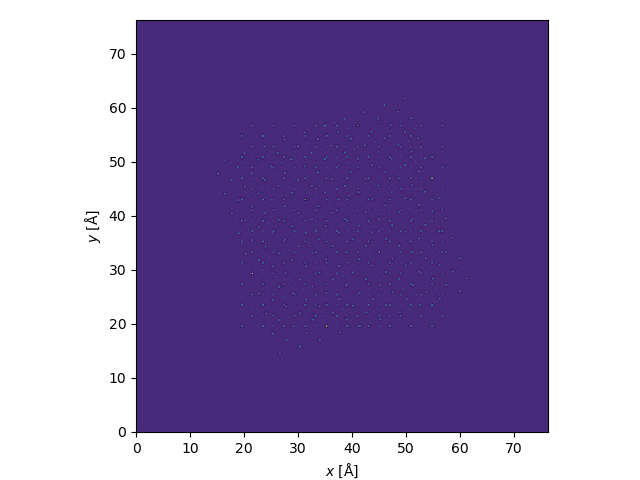

In [26]:
#getting information from exit wave in real space
inspection_wave = thte_0_20['Exit waves'][-1]
dimensions = inspection_wave.extent
image = inspection_wave.intensity().array
inspection_wave.show()

In [32]:
#getting informaiton from diffraiction plane / fourier space
difraction_image = inspection_wave.diffraction_patterns().array
difraciton_sampling = inspection_wave.diffraction_patterns().sampling


In [33]:
dimensions

(76.297675545, 76.297675545)

In [35]:
thte_0_20.keys()

dict_keys(['Rotation', 'ASE structure', 'Potential', 'Exit waves'])

In [36]:
image_rot_dict = image_files(thte_0_20)

In [37]:
filename = 'srtio3_theta20_rep_10'
path = os.getcwd()+'/data/' + filename


In [42]:
for i in image_rot_dict:
    print(np.shape(image_rot_dict[i]))

(21,)
(21, 1024, 1024)
(21, 2)
(21, 683, 683)
(21, 2)


In [38]:
np.savez(path, image_rot_dict['Rotation'], image_rot_dict['Intensity_real'],
        image_rot_dict['dimensions_real'], 
        image_rot_dict['Intensity_difraction'],
        image_rot_dict['Difraction sampling'],  allow_pickle=True,
        )


In [ ]:
data = np.array(image_rot_dict['Intensity_real'])

[########################################] | 100% Completed | 107.31 ms


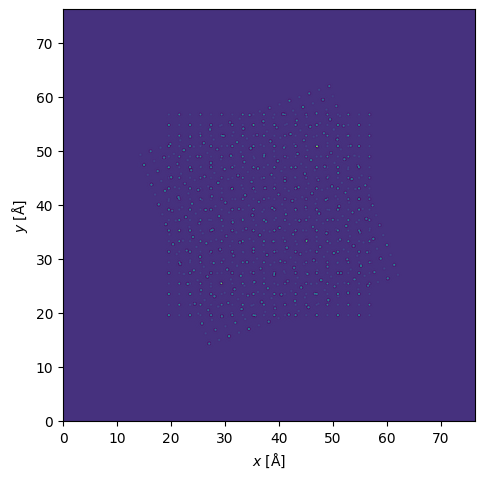

In [79]:
zar_tester = abtem.array.from_zarr(filename)
zar_tester.show()

In [80]:
type(zar_tester)

abtem.waves.Waves

[########################################] | 100% Completed | 104.59 ms


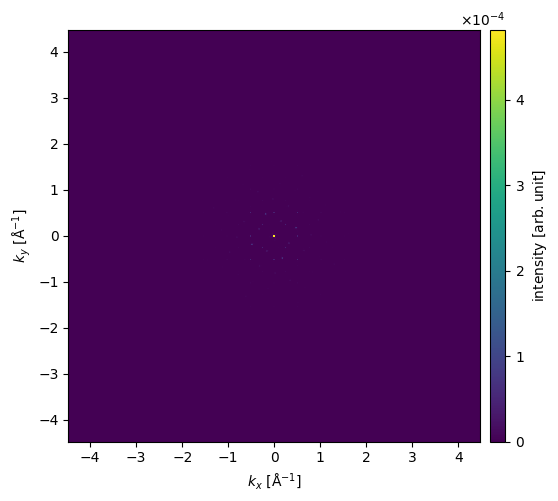

In [122]:
zar_tester.diffraction_patterns().block_direct().show(units="1/Å", cbar=True)

In [ ]:
image_rot_dict.keys()

dict_keys(['Rotation', 'Intensity_real', 'dimensions_real', 'Intensity_difraction', 'Difraction sampling'])

In [45]:

arr = np.array(image_rot_dict['Intensity_difraction'])

arr = np.array([image_rot_dict['Rotation'], image_rot_dict['Intensity_real'],
        image_rot_dict['dimensions_real'], 
        image_rot_dict['Intensity_difraction'],
        image_rot_dict['Difraction sampling']])

# reshaping the array from 3D
# matrice to 2D matrice.
arr_reshaped = arr.reshape(arr.shape[0], -1)

# saving reshaped array to file.
np.savetxt("difraction.txt", arr_reshaped)

# retrieving data from file.
loaded_arr = np.loadtxt("difraction.txt")

load_original_arr = loaded_arr.reshape(
	loaded_arr.shape[0], loaded_arr.shape[1] // arr.shape[2], arr.shape[2])

# check the shapes:
print("shape of arr: ", arr.shape)
print("shape of load_original_arr: ", load_original_arr.shape)

# check if both arrays are same or not:
if (load_original_arr == arr).all():
	print("Yes, both the arrays are same")
else:
	print("No, both the arrays are not same")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (5, 21) + inhomogeneous part.

In [ ]:
arr.shape[2]

512

In [ ]:
loaded_arr.shape[0], loaded_arr.shape[1] // arr.shape[2], arr.shape[2]

(21, 512, 512)

In [ ]:
512*512

262144

In [ ]:
def load_exit_waves(filepath):
    



In [89]:
type(zar_tester.array)

dask.array.core.Array

In [117]:
zar_tester.extent

(76.297675545, 76.297675545)

In [116]:
zar_tester.diffraction_patterns().extent

(-8.938673362306558, -8.938673362306558)

In [ ]:
def save_outcome(folder_path, filename, data, metadata = 'empty'):
    arr_reshaped = data.reshape(data.shape[0], -1)
    new_folder = folder_path + "/"+ filename 
    if not os.path.exists(new_folder):
        os.makedirs(folder_path + "/"+ filename)
        np.savetxt(folder_path + "/"+ filename + "/intensity.txt", arr_reshaped)
        if metadata != 'empty':
            np.savetxt(folder_path + "/"+ filename + "/metadata.txt", metadata, )
    else:
        print('Error: Folder already exists')
   
    
    
def load_outcome(filepath):
    data  = np.loadtxt(filepath + "/intensity.txt")
    #metadata = np.loadtxt(filepath + "/metadata.txt")
    return data, metadata

In [31]:
save_outcome('data', 'rot_trans_test', np_set)

Error: Folder already exists


In [32]:
#loaded_outcome = np.loadtxt('data/rot_trans_testintensity.txt')
%matplotlib widget

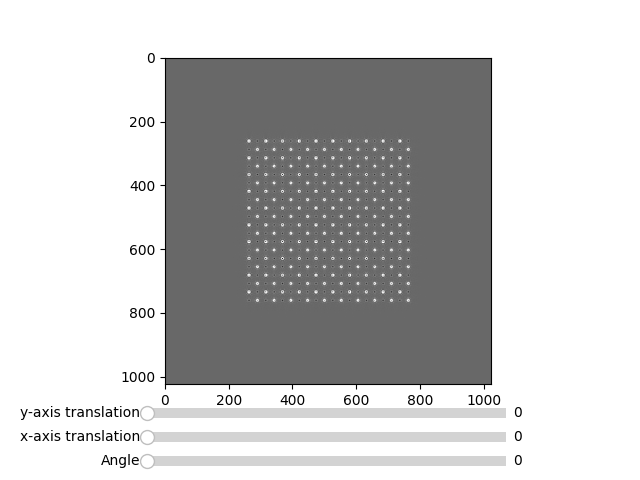

In [34]:
from matplotlib.widgets import Slider
file_path = "C:/Users/Bruger/Desktop/Python/Moire/moire_visualization/data/rot_trans_test/intensity.txt"

loaded_arr = np.loadtxt(file_path)
#x_pixel = int(np.sqrt(loaded_arr.shape[1]))
#load_original_arr = loaded_arr.reshape(loaded_arr.shape[0], x_pixel,x_pixel)

load_original_arr = loaded_arr.reshape(4,3,3,1024,1024)

data = np_set
#data = np.random.randint(10, size=(10, 10, 10, 5, 5))
# current layer index start with the first layer 
id_theta = 0
idx = 0
idy = 0

# figure axis setup 
fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)

# display initial image 
im_h = ax.imshow(data[id_theta,idx,idy, :, :], cmap='binary', interpolation='nearest')

# setup a slider axis and the Slider
diff = 0.05
ax_theta = plt.axes([0.23, 0.02, 0.56, 0.04])
ax_x = plt.axes([0.23, 0.02+diff, 0.56, 0.04])
ax_y = plt.axes([0.23, 0.02+diff*2, 0.56, 0.04])

slider_theta = Slider(ax_theta, 'Angle', 0, data.shape[0]-1, valinit=id_theta)
slider_x = Slider(ax_x, 'x-axis translation', 0, data.shape[1]-1, valinit=idx)
slider_y = Slider(ax_y, 'y-axis translation', 0, data.shape[2]-1, valinit=idy)

# update the figure with a change on the slider 
def update_sliders(val):
    id_theta = int(round(slider_theta.val))
    idx = int(round(slider_x.val))
    idy = int(round(slider_y.val))
    im_h.set_data(data[id_theta,idx,idy, :, :])




slider_theta.on_changed(update_sliders)
slider_x.on_changed(update_sliders)
slider_y.on_changed(update_sliders)



plt.show()

In [ ]:

arr = np.array(image_rot_dict['Intensity_difraction'])

arr = np.array([image_rot_dict['Rotation'], image_rot_dict['Intensity_real'],
        image_rot_dict['dimensions_real'], 
        image_rot_dict['Intensity_difraction'],
        image_rot_dict['Difraction sampling']])

# reshaping the array from 3D
# matrice to 2D matrice.
arr_reshaped = arr.reshape(arr.shape[0], -1)

# saving reshaped array to file.
np.savetxt("difraction.txt", arr_reshaped)

# retrieving data from file.
loaded_arr = np.loadtxt("difraction.txt")

load_original_arr = loaded_arr.reshape(
	loaded_arr.shape[0], loaded_arr.shape[1] // arr.shape[2], arr.shape[2])

# check the shapes:
print("shape of arr: ", arr.shape)
print("shape of load_original_arr: ", load_original_arr.shape)

# check if both arrays are same or not:
if (load_original_arr == arr).all():
	print("Yes, both the arrays are same")
else:
	print("No, both the arrays are not same")